# Implementation of SGD with stress as loss function for visualization of temporal graphs

As we have moved all functions to a Python file, we have commented them out here.

In [2]:
from HotVisFunctions import *
from SGDStressFunctions import *
import csv

/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Shortest paths of PathData

To be able o use the algorithm also for PathData, we need a function wich returns the distance matrix of a Pathdata object.

In [18]:
''' def shortest_paths_path_data(path_data: pp.PathData):
    """
    Computes the shortest path distances between all pairs of nodes in a PathData object using a second-order model.

    Args:
        path_data (pp.PathData): The `PathData` object containing the nodes for which shortest paths are calculated.

    Returns:
        torch.Tensor: A matrix of shortest path distances between all node pairs, where `dist[i, j]` represents the 
                      shortest path distance from node `i` to node `j`.

    Example:
        >>> dist_matrix = shortest_paths_path_data(path_data)
        >>> print(dist_matrix)
        tensor([[0., 1., 2.],
                [1., 0., 3.],
                [2., 3., 0.]])
    """
    # create second order model
    mo_graph = pp.MultiOrderModel.from_PathData(path_data, max_order=2, cached=True)
    # create distance matrix for all nodes: default value is 'inf'
    dist = torch.full((mo_graph.layers[1].n, mo_graph.layers[1].n), float('inf'))
    # get distances of second order model
    mo_dist, _ = pp.algorithms.shortest_paths.shortest_paths_dijkstra(mo_graph.layers[2])
    # iterate through values adjancecy matrix
    for i in range(mo_dist.shape[0]):
        for j in range(mo_dist.shape[0]):
                # get node ids
                node_i = mo_graph.layers[2].mapping.node_ids[i]
                node_j = mo_graph.layers[2].mapping.node_ids[j]
                if(dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] > mo_dist[i,j] + 1):
                    # write distance into 'dist'
                    dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] = mo_dist[i,j] + 1
    
    # insert all distances of length 1
    for node in mo_graph.layers[2].nodes:
        dist[path_data.mapping.to_idx(node[0]), path_data.mapping.to_idx(node[1])] = 1

    # fill diagonals with 0
    torch.Tensor.fill_diagonal_(dist, 0)

    return dist'''

We test the function from above and the ``` pp.algorithms.temporal_shortest_paths``` on simple examples.

In [3]:
g = pp.Graph.from_edge_list([('a', 'b'), ('b','c'), ('b','d')])
test_path_data = pp.PathData(g.mapping)
test_path_data.append_walk(('a', 'b', 'c'))
test_path_data.append_walk(('b', 'd'))
test_path_data.append_walk(('b', 'a'))

test_temp_graph =pp.TemporalGraph.from_edge_list([('a', 'b', 1), ('b', 'c', 1), ('b', 'a', 2), ('b', 'd', 1)])
dist, _ = pp.algorithms.temporal_shortest_paths(test_temp_graph, 1)
print(dist)
print(test_temp_graph.mapping)
print(shortest_paths_path_data(test_path_data))

100%|██████████| 2/2 [00:00<00:00, 237.46it/s]

[[ 0.  1. inf inf]
 [ 1.  0.  1.  1.]
 [inf inf  0. inf]
 [inf inf inf  0.]]
a -> 0
b -> 1
c -> 2
d -> 3

tensor([[0., 1., 2., inf],
        [1., 0., 1., 1.],
        [inf, inf, 0., inf],
        [inf, inf, inf, 0.]])


It is easy to see, that the functions output correct matrices.

## Implementation of the algorithm

At first, we implement the stress function. It should be able to get torch.nn.Embedding and torch.Tensor as input.

In [20]:
'''def stress_loss(layout: torch.nn.Embedding|torch.Tensor, shortest_path_dist: torch.Tensor) -> float:

    """
    Computes the stress loss between the pairwise distances in a layout and the corresponding shortest path distances.
    It can be used to minimize the difference between the distances of points in a layout and the original distances (e.g., shortest path distances in a graph).

    Args:
        layout (torch.nn.Embedding or torch.Tensor): The layout of nodes, either as an `Embedding` or a 2D tensor.
        dist (torch.Tensor): A tensor of shortest path distances between node pairs in the original graph.

    Returns:
        float: The computed stress loss value.

    Example:
        >>> layout = torch.rand((5, 2))  # Example layout with 5 nodes in 2D space
        >>> dist = torch.rand((5, 5))  # Example shortest path distance matrix
        >>> loss = stress_loss(layout, dist)
        >>> print(loss)
    """

    loss = 0

    if isinstance(layout, torch.nn.Embedding):
        for i in range(layout.num_embeddings):
            for j in range(layout.num_embeddings):
                if j != i:
                    delta = layout(torch.tensor(i)) - layout(torch.tensor(j))
                    distance = torch.norm(delta)
                    loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  

    elif isinstance(layout, torch.Tensor):
        for i in range(layout.shape[0]):
            for j in range(layout.shape[0]):
                if j != i:
                    delta = layout[i] - layout[j]
                    distance = torch.norm(delta)
                    loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  
    else:
        return None

    return loss/2'''

Then we implement a version using the torch libary. This version slightly differs from the one of paper. This is because the papers version can't be implemented using the classic torch trainingloop. Additionally we implement a version using the adam oprimizer instead of SGD.

In [21]:
'''def SGD_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None) -> tuple[dict, bool]:
    """
    Performs stress minimization using stochastic gradient descent (SGD) to optimize the layout of nodes in a graph or path data.

    This method aims to learn a 2D layout for the nodes, such that the pairwise distances between nodes in the layout 
    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference 
    between the layout distances and the original shortest path distances.

    Args:
        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.
        iterations (int): The number of iterations for the optimization process.
        delta (int, optional): The temporal window size for paths in temporal graphs. Not considered for Pathdata objects. Default is 1.
        learning_rate (float, optional): The learning rate for the SGD optimizer. Default is 0.01.
        initial_positions (torch.Tensor, optional): The initial 2D positions of the nodes for layout optimization. If None, random positions are used.

    Returns:
        dict: A dictionary with node identifiers as keys and their corresponding 2D layout coordinates as values.
        bool: True, if layout is not random

    Example:
        >>> data = pp.TemporalGraph(...)  # A temporal graph object
        >>> layout = SGD_stress_torch(data, iterations=1000)
        >>> print(layout)
        {'node1': [x1, y1], 'node2': [x2, y2], ...}
    """

    # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}, False
    
    dist = torch.tensor(dist)
    
    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        positions = torch.rand((graph.n, 2))*100
        layout = {}
        for node in graph.nodes:
            layout[node] = positions[graph.mapping.to_idx(node)].tolist()
        return layout, False

    # initialize embedding
    num_nodes =  graph.n 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    # initialize initial_positions
    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.n, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    # training loop
    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")

    # create layout out of embedding
    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout, True

def Adam_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None):

    """
    Performs stress minimization using the Adam optimizer to optimize the layout of nodes in a graph or path data.

    This method aims to learn a 2D layout for the nodes such that the pairwise distances between nodes in the layout
    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference
    between the layout distances and the original shortest path distances. The Adam optimizer is used for gradient-based 
    optimization of the layout.

    Args:
        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.
        iterations (int): The number of iterations for the optimization process.
        delta (int, optional): The temporal window size for paths in temporal graphs. Not considered for Pathdata objects. Default is 1.
        learning_rate (float, optional): The learning rate for the SGD optimizer. Default is 0.01.
        initial_positions (torch.Tensor, optional): The initial 2D positions of the nodes for layout optimization. If None, random positions are used.

    Returns:
        dict: A dictionary with node identifiers as keys and their corresponding 2D layout coordinates as values.
        bool: True, if layout is not random

    Example:
        >>> data = pp.TemporalGraph(...)  # A temporal graph object
        >>> layout = Adam_stress_torch(data, iterations=1000)
        >>> print(layout)
        {'node1': [x1, y1], 'node2': [x2, y2], ...}
    """

    # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}, False

    dist = torch.tensor(dist)

    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        positions = torch.rand((graph.n, 2))*100
        layout = {}
        for node in graph.nodes:
            layout[node] = positions[graph.mapping.to_idx(node)].tolist()
        return layout, False

    # initialize embedding
    num_nodes =  graph.n 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    # initialize initial_positions
    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.n, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and lossfunction
    optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    # training loop
    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")
            
    # create layout out of embedding
    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout, True'''

Additionally we implement a version wich follows exactly the paper. Thois one might converge faster in less epochs, but every epoch has longer runtime.

In [27]:
'''def SGD_stress_paper(data: pp.TemporalGraph|pp.PathData, iterations: int, delta:int = 1, initial_positions: torch.Tensor | None = None, learning_rate: float = 0.01, eta: float = 1, decay: float = 0.5) -> tuple[dict, bool]:
    
    """
    Performs stress minimization using Stochastic Gradient Descent (SGD) to optimize the layout of nodes in a graph or path data.

    This method aims to learn a 2D layout for the nodes such that the pairwise distances between nodes in the layout 
    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference 
    between the layout distances and the original shortest path distances. The optimizer updates the node positions 
    iteratively based on the gradient of the stress function.

    The algorithm follows the paper: 
    Börsig, K., Brandes, U., Pasztor, B. (2020). Stochastic Gradient Descent Works Really Well for Stress Minimization. 
    In: Auber, D., Valtr, P. (eds) Graph Drawing and Network Visualization. GD 2020. Lecture Notes in Computer Science(), vol 12590. Springer, Cham. 
    https://doi.org/10.1007/978-3-030-68766-3_2

    Args:
        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.
        iterations (int): The number of iterations for the optimization process.
        delta (int, optional): The temporal window size for temporal graphs. Not considered for Pathdata objects. Default is 1.
        initial_positions (torch.Tensor, optional): The initial 2D positions of the nodes for layout optimization. If None, random positions are used.
        learning_rate (float, optional): The learning rate for the SGD optimizer. Default is 0.01.
        eta (float, optional): A scaling factor that affects the step width, based on the shortest path distance. Default is 1.
        decay (float, optional): The decay rate for the learning rate over iterations. Default is 0.5.

    Returns:
        dict: A dictionary with node identifiers as keys and their corresponding 2D layout coordinates as values.
        bool: True, if layout is not random

    Example:
        >>> data = pp.TemporalGraph(...)  # A temporal graph object
        >>> layout = SGD_stress_paper(data, iterations=1000)
        >>> print(layout)
    """

     # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}, False
    
    dist = torch.tensor(dist)
    
    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        positions = torch.rand((graph.n, 2))*100
        layout = {}
        for node in graph.nodes:
            layout[node] = positions[graph.mapping.to_idx(node)].tolist()
        return layout, False
    
    # initialize initial_positions if not given
    if initial_positions is None:
        initial_positions = torch.rand((graph.n, 2))*100
    
    positions = torch.clone(initial_positions)

    # get all possible node pairs
    #node_pairs = torch.combinations(torch.arange(graph.n), r=2, with_replacement=False)
    #node_pairs = torch.arange(graph.n).view(1, -1) @ torch.arange(graph.n).view(-1,1)
    node_pairs = torch.cartesian_prod(torch.arange(graph.n), torch.arange(graph.n))
    node_pairs = node_pairs[node_pairs[:, 0] != node_pairs[:, 1]]

    for i in range(iterations):
        # shuffle order of node pairs
        shuffled_pairs = node_pairs[torch.randperm(node_pairs.size(0))]
        # calculate step width (called eta in paper)
        step_width = eta * torch.exp(torch.tensor(-decay * i))

        # iterate through node pairs
        for pair in shuffled_pairs:
            # get distance between pairs
            shortest_path_dist = dist[pair[0], pair[1]]
            # skip if nodes are the same
            if(shortest_path_dist == 0):
               continue
            # calculate learning rate
            learning_rate = min(1, ((1 / (shortest_path_dist ** 2)) * step_width)) / 2
            # calculate distance of nodes in layout (not in graph)
            norm = torch.norm(positions[pair[0]] - positions[pair[1]])
            # determine distace and dirction the nodes are moved 
            delta = (norm - shortest_path_dist) / norm * (positions[pair[0]] - positions[pair[1]])
            positions[pair[0]] -= learning_rate * delta
            positions[pair[1]] += learning_rate * delta

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Stress: {stress_loss(positions, dist):.4f}")

    # create layout 
    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout, True'''

## Test

Next we test the algorithms on a graph

In [4]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
# read colors
colors = {}
with open('graphs/synthetic_graph/colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

In [5]:
layout_paper, _ = SGD_stress_paper(graph, iterations=30, delta = 1, learning_rate=0.01)
layout_adam, _ = Adam_stress_torch(graph, iterations=500, delta = 1, learning_rate=0.5)
layout_torch, _ = SGD_stress_torch(graph, iterations=100, delta = 1, learning_rate=0.01)

100%|██████████| 20000/20000 [00:11<00:00, 1751.23it/s]


Epoch [10/30], Stress: 66.8942
Epoch [20/30], Stress: 66.8686
Epoch [30/30], Stress: 66.8685


100%|██████████| 20000/20000 [00:10<00:00, 1960.11it/s]


Epoch [10/500], Loss: 1124657.8773
Epoch [20/500], Loss: 811358.6785
Epoch [30/500], Loss: 578174.9257
Epoch [40/500], Loss: 409219.3849
Epoch [50/500], Loss: 287623.2284
Epoch [60/500], Loss: 200395.8149
Epoch [70/500], Loss: 137926.6630
Epoch [80/500], Loss: 93436.5075
Epoch [90/500], Loss: 62109.0703
Epoch [100/500], Loss: 40434.0609
Epoch [110/500], Loss: 25753.7574
Epoch [120/500], Loss: 16042.3313
Epoch [130/500], Loss: 9774.5193
Epoch [140/500], Loss: 5831.3366
Epoch [150/500], Loss: 3413.9150
Epoch [160/500], Loss: 1969.6069
Epoch [170/500], Loss: 1128.1694
Epoch [180/500], Loss: 649.5713
Epoch [190/500], Loss: 383.2232
Epoch [200/500], Loss: 237.6952
Epoch [210/500], Loss: 159.2369
Epoch [220/500], Loss: 117.2303
Epoch [230/500], Loss: 94.7403
Epoch [240/500], Loss: 82.6183
Epoch [250/500], Loss: 76.0022
Epoch [260/500], Loss: 72.3252
Epoch [270/500], Loss: 70.2322
Epoch [280/500], Loss: 69.0055
Epoch [290/500], Loss: 68.2621
Epoch [300/500], Loss: 67.7963
Epoch [310/500], Los

100%|██████████| 20000/20000 [00:09<00:00, 2147.87it/s]


Epoch [10/100], Loss: 68.4326
Epoch [20/100], Loss: 66.9550
Epoch [30/100], Loss: 66.8216
Epoch [40/100], Loss: 66.7623
Epoch [50/100], Loss: 66.7341
Epoch [60/100], Loss: 66.7202
Epoch [70/100], Loss: 66.7133
Epoch [80/100], Loss: 66.7096
Epoch [90/100], Loss: 66.7074
Epoch [100/100], Loss: 66.7061


All algorithms cnverge to a similar value. This is an indicator that they work.

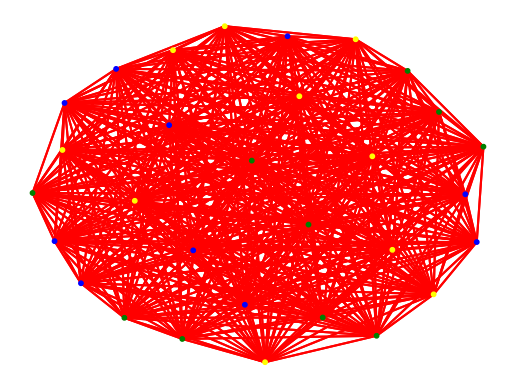

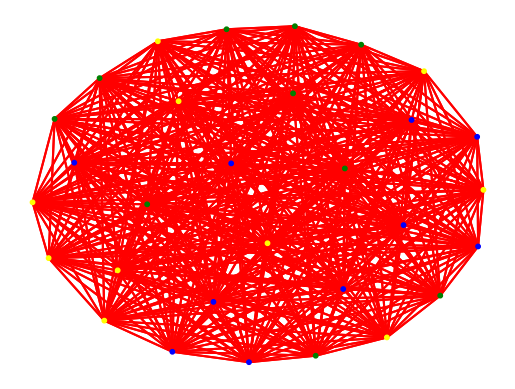

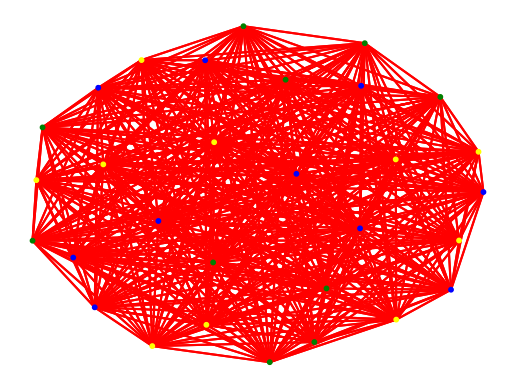

In [6]:
pp.plot(graph.to_static_graph(), layout=layout_adam, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_torch, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_paper, backend='matplotlib', **style)

Next we test the algorithms on path data.

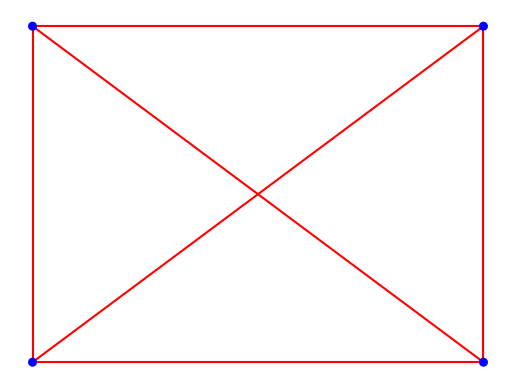

In [7]:
tedges = [('a', 'b', 1), ('b', 'c', 3), ('d', 'c', 4)]
test_graph = pp.TemporalGraph.from_edge_list(tedges)
test_layout= {'a':[0,0], 'b':[1,0], 'c':[0,1], 'd':[1,1]}

# create PathData object with same structure
test_paths = pp.PathData(test_graph.mapping)


test_paths.append_walk(['a', 'b', 'd', 'c', 'a', 'b', 'd'])
test_paths.append_walk(['a', 'd', 'b', 'c'])


test_m = pp.MultiOrderModel.from_PathData(test_paths, 2, cached=True)
pp.plot(test_m.layers[1], layout=test_layout, backend="matplotlib")

In [8]:
layout_paper, _ = SGD_stress_paper(test_paths, iterations=30, delta = 1, learning_rate=0.01)
layout_adam, _ = Adam_stress_torch(test_paths, iterations=500, delta = 1, learning_rate=0.5)
layout_torch, _ = SGD_stress_torch(test_paths, iterations=100, delta = 1, learning_rate=0.01)

/workspaces/pathpyG/src/pathpyG/visualisations/Project_JS/SGDStressFunctions.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.tensor(dist, device=device)
/workspaces/pathpyG/src/pathpyG/visualisations/Project_JS/SGDStressFunctions.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.tensor(dist, device=device)


Epoch [10/30], Stress: 1.1550
Epoch [20/30], Stress: 1.1523
Epoch [30/30], Stress: 1.1523
Epoch [10/500], Loss: 10144.8662
Epoch [20/500], Loss: 7225.1025
Epoch [30/500], Loss: 5041.9668
Epoch [40/500], Loss: 3448.4536
Epoch [50/500], Loss: 2311.4194
Epoch [60/500], Loss: 1516.7593
Epoch [70/500], Loss: 976.0589
Epoch [80/500], Loss: 615.3103
Epoch [90/500], Loss: 378.1609
Epoch [100/500], Loss: 225.4249
Epoch [110/500], Loss: 129.9502
Epoch [120/500], Loss: 72.3870
Epoch [130/500], Loss: 39.0434
Epoch [140/500], Loss: 20.5405
Epoch [150/500], Loss: 10.7287
Epoch [160/500], Loss: 5.7691
Epoch [170/500], Loss: 3.3872
Epoch [180/500], Loss: 2.3049
Epoch [190/500], Loss: 1.8420
Epoch [200/500], Loss: 1.6571
Epoch [210/500], Loss: 1.5889
Epoch [220/500], Loss: 1.5660
Epoch [230/500], Loss: 1.5591
Epoch [240/500], Loss: 1.5572
Epoch [250/500], Loss: 1.5564
Epoch [260/500], Loss: 1.5549
Epoch [270/500], Loss: 1.5500
Epoch [280/500], Loss: 1.5328
Epoch [290/500], Loss: 1.4780
Epoch [300/500],

/workspaces/pathpyG/src/pathpyG/visualisations/Project_JS/SGDStressFunctions.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.tensor(dist, device=device)


Epoch [20/100], Loss: 1109.2841
Epoch [30/100], Loss: 400.7617
Epoch [40/100], Loss: 147.9818
Epoch [50/100], Loss: 55.8771
Epoch [60/100], Loss: 21.7583
Epoch [70/100], Loss: 8.9586
Epoch [80/100], Loss: 4.1087
Epoch [90/100], Loss: 2.2550
Epoch [100/100], Loss: 1.5400


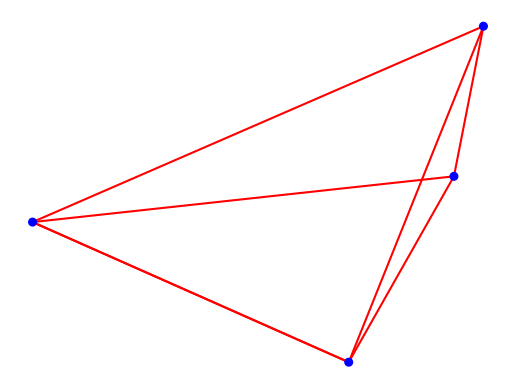

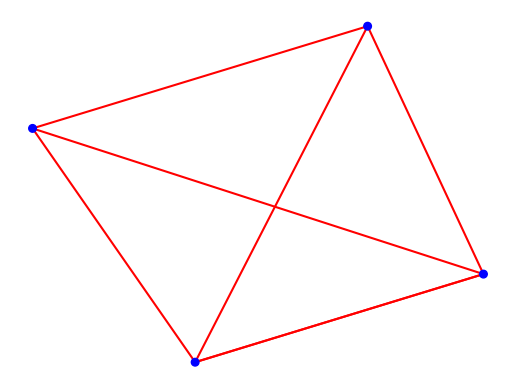

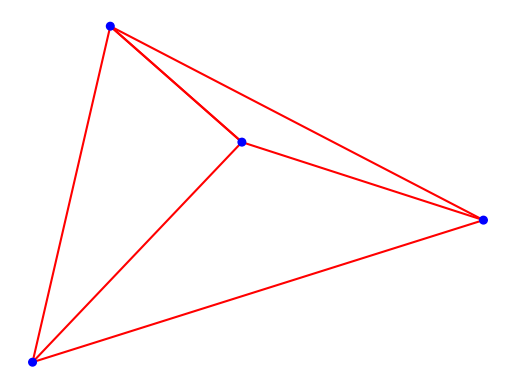

In [9]:
pp.plot(test_m.layers[1], layout=layout_paper, backend="matplotlib")
pp.plot(test_m.layers[1], layout=layout_adam, backend="matplotlib")
pp.plot(test_m.layers[1], layout=layout_torch, backend="matplotlib")